In [1]:
# Import data science libraries
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read in the clean data
df = pd.read_csv('../Data/combined_admissions_characteristics.csv')

C:\Users\ceero\AppData\Local\Temp\ipykernel_11972\2239975870.py:2: DtypeWarning: Columns (56,58,72,74,80,82,84,86,88,90,92,94,96,98,100,102,104,106,108,121,147,184,185,198) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../Data/combined_admissions_characteristics.csv')


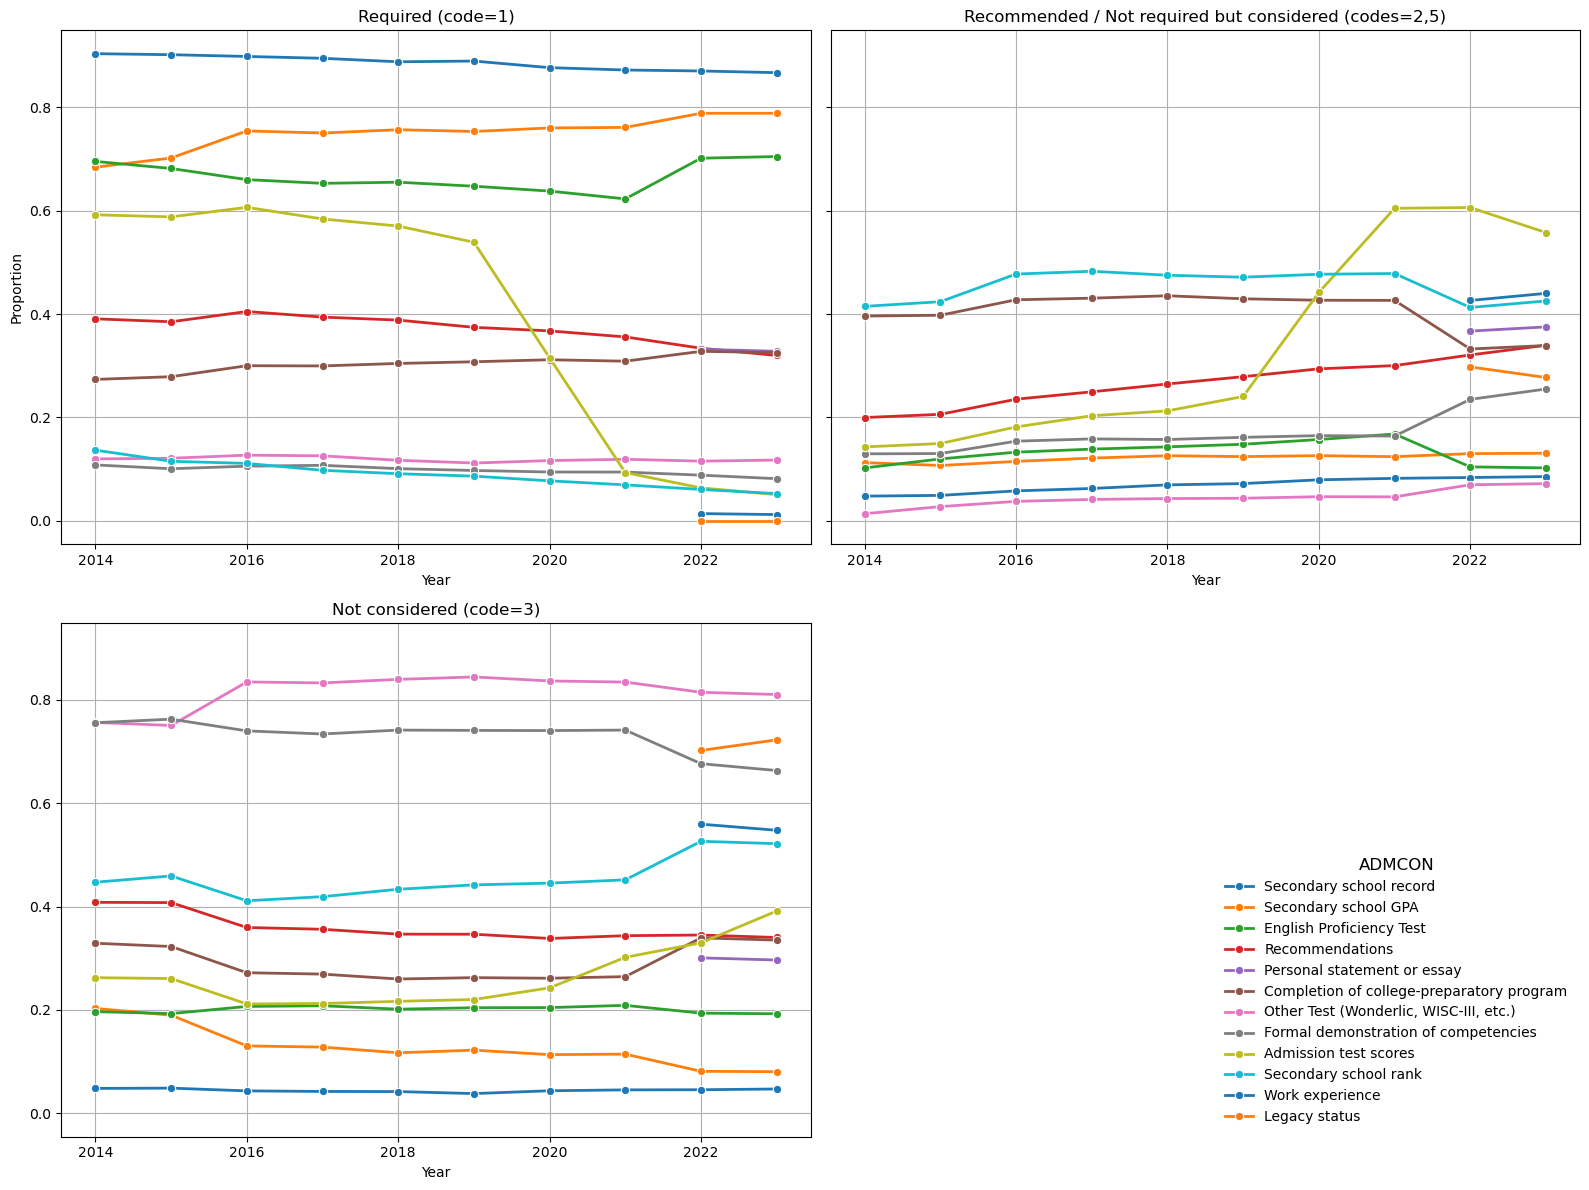

In [3]:
# Get proportions (fraction equal to 1) of each ADMCON over time
# Make a table with each ADMCON as columns and years as rows
admcon_cols = [col for col in df.columns if col.startswith('ADMCON')]
# For each year, compute proportion of rows where ADMCON == 1
admcon_trends = df.groupby('year')[admcon_cols].apply(lambda x: (x == 1).sum() / x.count()).reset_index()
admcon_trends_melted = admcon_trends.melt(id_vars='year', var_name='ADMCON', value_name='Proportion')
# Determine ordering of ADMCONs based on 2022 proportions (descending)
# Ensure year column is numeric if it's not already
admcon_trends['year'] = pd.to_numeric(admcon_trends['year'], errors='coerce')
row_2022 = admcon_trends[admcon_trends['year'] == 2022]
if not row_2022.empty:
    ordered_admcons = row_2022.set_index('year').iloc[0][admcon_cols].sort_values(ascending=False).index.tolist()
else:
    # Fallback to the natural order of ADMCON columns
    ordered_admcons = admcon_cols
# Codes to plot and their interpretations
plot_specs = {
    1: 'Required',
    2: 'Recommended',
    3: 'Not considered',
    5: 'Not required but considered'
}
legend_translation = {
    'ADMCON1': 'Secondary school GPA',
    'ADMCON2': 'Secondary school rank',
    'ADMCON3': 'Secondary school record',
    'ADMCON4': 'Completion of college-preparatory program',
    'ADMCON5': 'Recommendations',
    'ADMCON6': 'Formal demonstration of competencies',
    'ADMCON7': 'Admission test scores',
    'ADMCON8': 'English Proficiency Test',
    'ADMCON9': 'Other Test (Wonderlic, WISC-III, etc.)',
    'ADMCON10': 'Work experience',
    'ADMCON11': 'Personal statement or essay',
    'ADMCON12': 'Legacy status'
}
# Create a 2x2 grid of plots: we'll use 3 subplots for data and reserve the 4th for the legend
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=True)
axes = axes.flatten()
# Prepare a distinct qualitative palette mapped to ADMCON order
palette_list = sns.color_palette('tab10', n_colors=len(admcon_cols))
palette_map = {adm: palette_list[i % len(palette_list)] for i, adm in enumerate(ordered_admcons)}
# Define plotting specs: combine codes 2 and 5 into one plot (combined = values in [2,5])
plot_groups = [([1], 'Required (code=1)'), ([2,5], 'Recommended / Not required but considered (codes=2,5)'), ([3], 'Not considered (code=3)')]
for ax, (codes, title) in zip(axes[:3], plot_groups):
    # compute proportions for these codes (if multiple, check membership)
    if len(codes) == 1:
        code = codes[0]
        trends_code = df.groupby('year')[admcon_cols].apply(lambda x: (x == code).sum() / x.count()).reset_index()
    else:
        trends_code = df.groupby('year')[admcon_cols].apply(lambda x: x.isin(codes).sum() / x.count()).reset_index()
    trends_code_melt = trends_code.melt(id_vars='year', var_name='ADMCON', value_name='Proportion')
    # plot with explicit palette and order so colors are consistent across subplots
    sns.lineplot(data=trends_code_melt, x='year', y='Proportion', hue='ADMCON', hue_order=ordered_admcons, palette=palette_map, marker='o', ax=ax, legend=(ax is axes[0]), linewidth=2)
    ax.set_title(title)
    ax.set_xlabel('Year')
    ax.set_ylabel('Proportion' if ax is axes[0] else '')
    ax.grid()
    # remove legend from top left grid
    if ax is axes[0]:
        ax.get_legend().remove()
# Prepare legend on the bottom-right subplot (axes[3]) instead of plotting data there
legend_ax = axes[3]
legend_ax.axis('off')
# Get handles/labels from the first data axis
handles, labels = axes[0].get_legend_handles_labels()
display_labels = [legend_translation.get(l, l) for l in labels]
# Place the legend inside the bottom-right subplot at lower right
legend_ax.legend(handles, display_labels, title='ADMCON', loc='lower right', frameon=False, fontsize=10, title_fontsize=12)
plt.tight_layout()
# Save plot to Output folder
plt.savefig('../Output/admcon_trends_subplot.png', dpi=600)
plt.show()

C:\Users\ceero\AppData\Local\Temp\ipykernel_11972\2684141058.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='year', y='SATPCT', hue='CONTROL', marker='o', palette='Set2', ci=None)


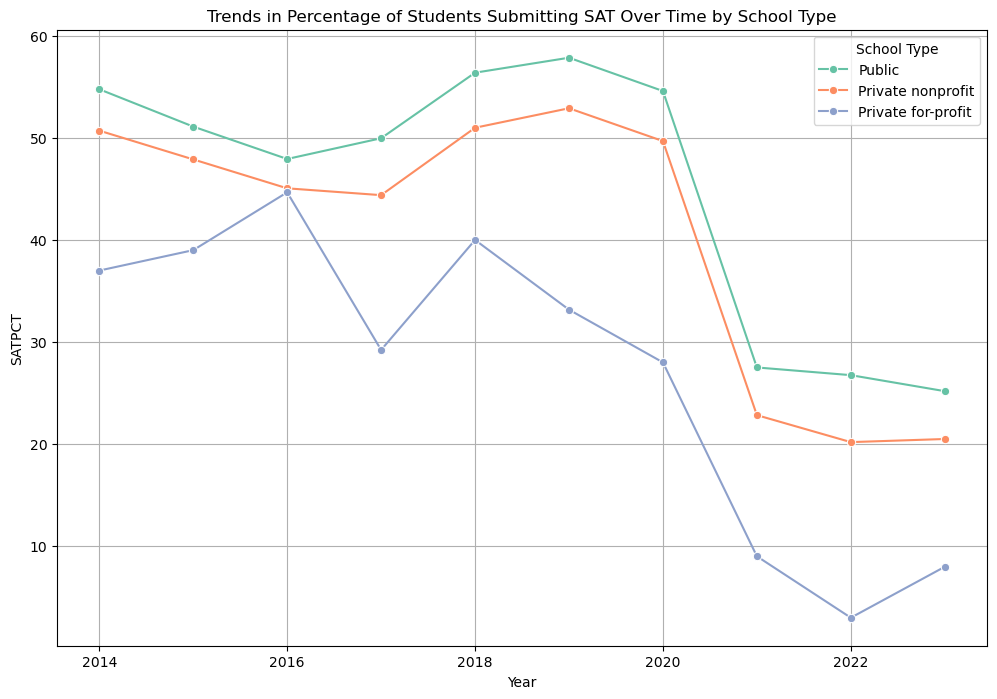

In [4]:
# Graph the trends in SATPCT over time by CONTROL group
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='year', y='SATPCT', hue='CONTROL', marker='o', palette='Set2', ci=None)
plt.title('Trends in Percentage of Students Submitting SAT Over Time by School Type')
plt.xlabel('Year')
plt.ylabel('SATPCT')
control_translation = {
    1: 'Public',
    2: 'Private nonprofit',
    3: 'Private for-profit'
}
plt.legend(title='School Type', labels=[control_translation.get(i, i) for i in range(1, 4)])
plt.grid() 
# save plot to Output folder
plt.savefig('../Output/satpct_trends_control.png', dpi=600)
plt.show()

In [5]:
# Map the numerical CONTROL values to descriptive labels
control_map = {
    1: 'Public',
    2: 'Private not-for-profit',
    3: 'Private for-profit'
}
df['CONTROL'] = df['CONTROL'].map(control_map)

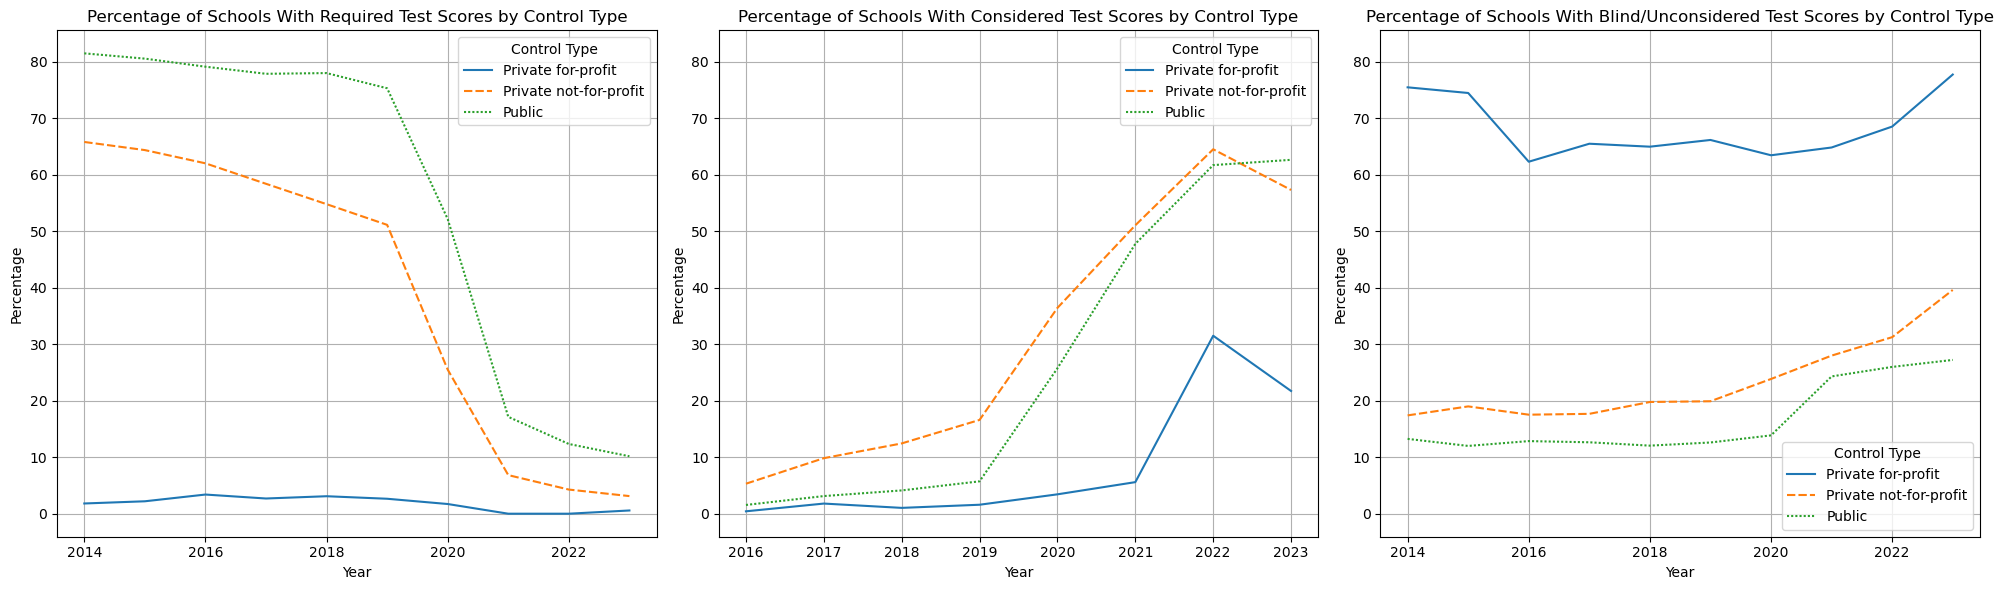

In [6]:
# Define the ADMCON7 values of interest
admcon7_values = {
    1: 'Required',
    5: 'Considered',
    3: 'Blind/Unconsidered'
}

# Create a plot for each ADMCON7 value
plt.figure(figsize=(20, 6)) # Adjusted figure size for horizontal layout

# Get the first axes object to share the y-axis with
ax0 = None

for i, (value, label) in enumerate(admcon7_values.items()):
    if i == 0:
        ax0 = plt.subplot(1, 3, i + 1) # Create the first subplot
    else:
        plt.subplot(1, 3, i + 1, sharey=ax0) # Create subsequent subplots and share the y-axis with the first one

    # Filter data for the current ADMCON7 value
    filtered_df = df[df['ADMCON7'] == value]

    # Calculate the percentage of the current ADMCON7 value by year and CONTROL
    percentage_df = filtered_df.groupby(['year', 'CONTROL']).size().unstack(fill_value=0)
    total_counts = df.groupby(['year', 'CONTROL']).size().unstack(fill_value=0)
    percentage_df = (percentage_df / total_counts) * 100

    # Plot the percentages
    sns.lineplot(data=percentage_df, ax=plt.gca()) # Plot on the current axes
    plt.title(f'Percentage of Schools With {label} Test Scores by Control Type')
    plt.xlabel('Year')
    plt.ylabel('Percentage')
    plt.grid(True)
    plt.legend(title='Control Type')

plt.tight_layout()
plt.savefig('../Output/controlVsTestScores.png') # Save the figure as a PNG file
plt.show()